# Programming Project - Data Mining
### <font color='grey'> WS 2020/2021 </font>
#### <font color='grey'> Laura Jahn 01426256, Nikola, Max, Peter, Raphael Bednarsky 01505310</font>


### Task1 - Exploratory Data Analysis
#### b.1) Implement HiSC Algorithm

Comments to the implementation of HiSC:
- The results for the example "basic_ext" are not the same as for the ELKI code. Interestingly, when we always choose the value with the highest distance as next step get better results (but mess up the simpler "basic" example. In the debugging from the ELKI we see that in the first round it should choose the datapoint with subspace distance 5 but does not and chooses one with higher distance. 
- In the paper the square root for the euclidian distance is missing in the definition of d1
- In the ELKI implementation they do not take the inverse combined preference vector, as would be described in the paper, when calculating d2


In [2]:
## 👉 TODO 🏃

import numpy as np
from sklearn import preprocessing
from sklearn import neighbors


np.set_printoptions(linewidth=120, formatter={'float': '{: 0.3f}'.format})

In [3]:
# set parameters

# The maximum absolute variance along a coordinate axis.
α = alpha = 0.01

# The number of nearest neighbors considered to determine the preference
k = 2

In [4]:
# import dataset
def process_csv(input_filename):
    """
    simple function to read csv files, save X and y
    can be adapted to use MinMax preprocessing to scale each dimension from 0 to 1
    """
    data = np.genfromtxt(input_filename, delimiter=' ',dtype='str')
    X = data[:,:-1].astype(float) # exclude last column --> labels
    y = data[:,-1] # labels
    
    # we may or may not need this later...
    #     min_max_scaler = preprocessing.MinMaxScaler()
    #     X = min_max_scaler.fit_transform(X)    
    return X, y


X, y = process_csv("../test_data/basic.csv")
#X, y = process_csv("../test_data/basic_ext.csv")

len_samples = len(X)
dimensions = len(X[0])

nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(X)
knn_distances, knn_indices = nbrs.kneighbors(X)

X, knn_indices

(array([[ 0.616,  0.310,  0.639,  0.449,  0.574],
        [ 0.007,  0.839,  0.370,  0.156,  0.412],
        [ 0.630,  0.867,  0.154,  0.163,  0.459]]),
 array([[0, 2],
        [1, 2],
        [2, 1]], dtype=int64))

In [5]:
# preprocessing: calculate preference vectors for all data points

def _distance(vec):
    return np.linalg.norm(vec, 2) # l2 by default

# distances = np.zeros([len_samples,len_samples]).astype(float)
# fill up l2 distance matrix (to determine k nearest neighbours)
# for i in range(len_samples):
#     distances[i][i] = np.inf # set diagonals to infinity so that they dont interfer
#     for j in range(len_samples-i):
#         j = i+j
#         if i==j:
#             continue
#         dist = _distance([X[i],X[j]])
#         distances[i][j] = dist
#         distances[j][i] = dist
    
def var_a(dimension, p, q):    
    pi_d_p = X[p][dimension]
    pi_d_q = X[q][dimension]    
    return (pi_d_q - pi_d_p)**2
        
       
# np.min(knn_distances)

wp = np.zeros(dimensions).astype(bool)

# preference vector point 0 (nearest neighbors: point 0, point 2)
wp[0] = (var_a(0, 0, 0) + var_a(0, 0, 2)) / k <= α # dim 1
wp[1] = (var_a(1, 0, 0) + var_a(1, 0, 2)) / k <= α # dim 2
wp[2] = (var_a(2, 0, 0) + var_a(2, 0, 2)) / k <= α # dim 3
wp[3] = (var_a(3, 0, 0) + var_a(3, 0, 2)) / k <= α # dim 4
wp[4] = (var_a(4, 0, 0) + var_a(4, 0, 2)) / k <= α # dim 5

wp

array([ True, False, False, False,  True])

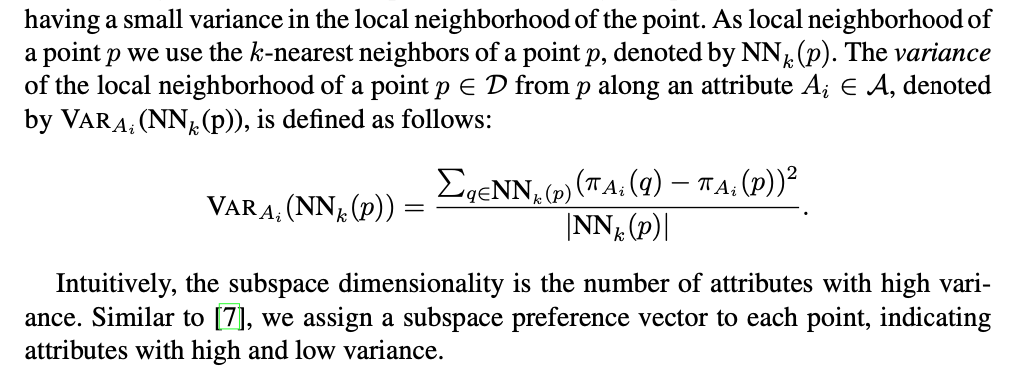

In [6]:
# compute variance VAR
from IPython.display import Image
Image("Variance.png")

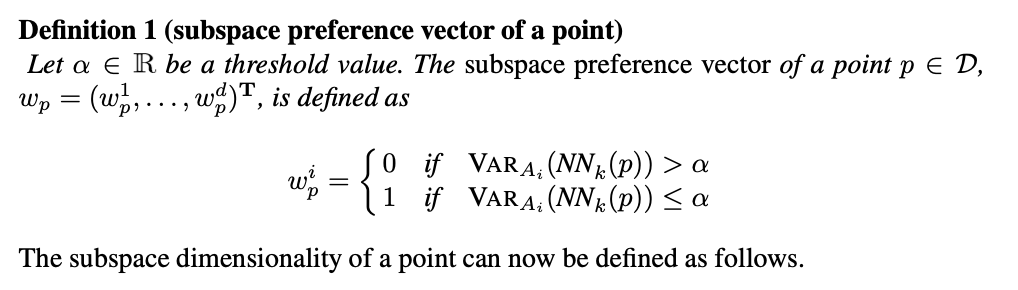

In [7]:
# set preference vector w
from IPython.display import Image
Image("Subspace_preference_vector.png")

In [8]:
def subsp_pref_vecs(data, knn_indices, alpha):
    """
    Input:
        data, np array of shape (n, dimensions), where each row is a data 
        point.
        knn_indices, np array of shape (n, k), where each row is a nearest 
        neighbour pairing and the first instance is the central node. 
        alpha, float, threshold for high variance.
    Returns:
        a matrix containing all the subspace preference vectors,
        as a numpy array.
    """
    k = knn_indices.shape[1]
    
    ## variance 
    q = data[knn_indices]
    # create p to subtract it from values of q in the right pattern
    p = np.repeat(data[knn_indices][:,0,:], repeats=k, axis=0).reshape(q.shape)
    var = np.sum((p-q)**2, axis=1) / k
    
    # return subspace preference vectors
    return var <= alpha

# Testing basic
alpha_basic = 0.01
k_basic = 2
X_basic, y_basic = process_csv("../test_data/basic.csv")
nbrs = neighbors.NearestNeighbors(n_neighbors=k_basic, algorithm="ball_tree").fit(X_basic)
knn_distances, knn_indices = nbrs.kneighbors(X_basic)
wp_basic = subsp_pref_vecs(X_basic, knn_indices, alpha_basic)
print(wp_basic)

# Testing basic_ext
alpha_ext = 0.006
k_ext = 3
X_ext, y_ext = process_csv("../test_data/basic_ext.csv")
nbrs = neighbors.NearestNeighbors(n_neighbors=k_ext, algorithm="ball_tree").fit(X_ext)
knn_distances, knn_indices = nbrs.kneighbors(X_ext)
wp_ext = subsp_pref_vecs(X_ext, knn_indices, alpha_ext)
print("\n~~~~~\n", wp_ext)

[[ True False False False  True]
 [False  True False  True  True]
 [False  True False  True  True]]

~~~~~
 [[False False False False False]
 [ True  True False  True  True]
 [False  True False  True  True]
 [False  True False  True  True]
 [False False False False False]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


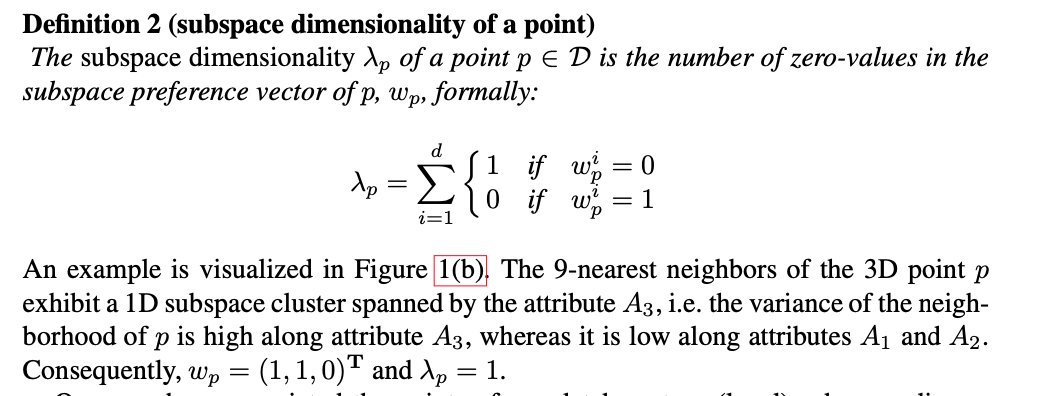

In [9]:
# set dimensionality lambda
from IPython.display import Image
Image("Subspace_dimensionality.png")

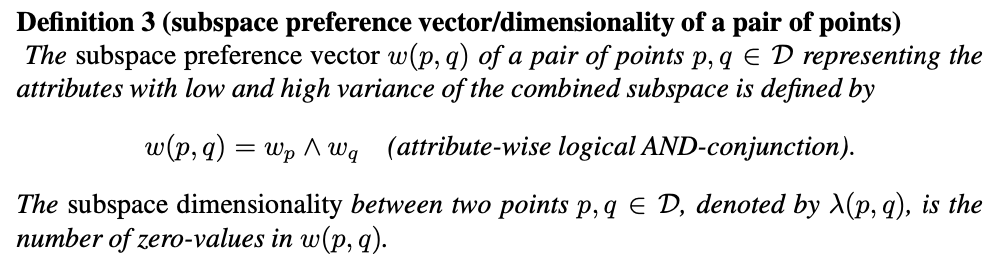

In [10]:
# set preference vector of a pair w(p, q)
# set dimensionality lambda of a pair lambda(p, q)
from IPython.display import Image
Image("pairOfPoints.png")

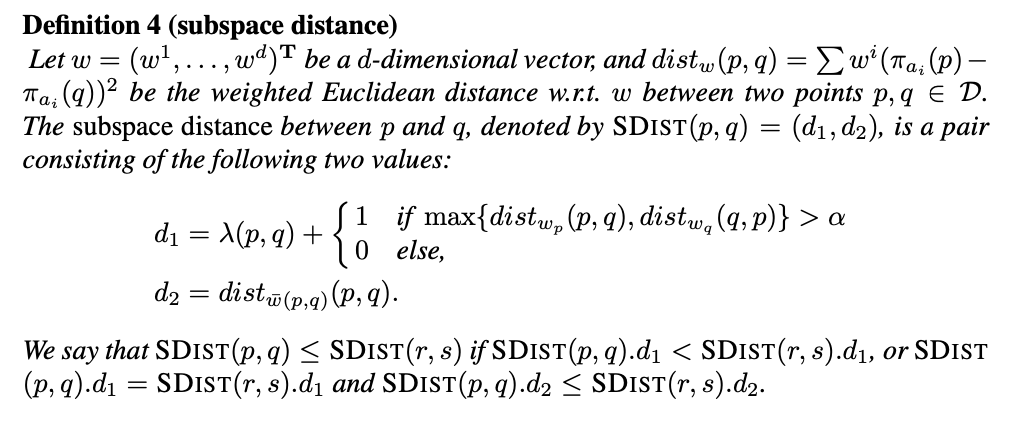

In [11]:
# compute distance between two points dist(p, q)
# set subspace distance between two points SDIST(p, q)
from IPython.display import Image
Image("Subspace_distance.png")

In [12]:
def lambda_pq(wp, p, q):
    """
    Input:
        wp (np.array) - a matrix containing all the subspace preference 
        vectors in its rows
        p, q (int) - indices indicating which wp's to compare.
    Output:
        subspace dimensionality (int), denoted as lamda(p, q) in the 
        definition 3 in the paper.
    """
    # not, because we want to count the zeros
    return np.sum( np.logical_not( np.logical_and( wp[p], wp[q])))

def distw_pq(data, wp, p, q):
    """
    Input: 
        wp (np.array) - a matrix containing all the subspace preference 
        vectors in its rows
        p, q (int) - indices indicating which wp's to compare. 
        data, np array of shape (n, dimensions), where each row is a data 
        point.
    Output:
        Weighted euclidian distance between the vectors with index p and q
        as given in definition 4.
    
    !! In definition 4 the square root at the end is missing in comparison to 
    !! the paper!
    """
    return (np.sum( (data[p] - data[q])**2 * wp[p] ))**(1/2)

# ## Testing
# data = X_basic
# wp = wp_basic
# p = 0
# q = 1
# print(distw_pq(data, wp, p, q))


def d1(data, wp, p, q, alpha):
    """
    Input:
        wp (np.array) - a matrix containing all the subspace preference 
        vectors in its rows
        p, q (int) - indices indicating which wp's to compare.
        data, np array of shape (n, dimensions), where each row is a data 
        point. 
        alpha (int), threshold for high variance
    Output:
        d1 (int) as referred to in defintion 4
    """
    if distw_pq(data, wp, p, q) > alpha or distw_pq(data, wp, q, p) > alpha:
        return lambda_pq(wp, p, q) + 1
    else:
        return lambda_pq(wp, p, q)

# ## Testing
# data = X_basic
# wp = wp_basic
# p = 0
# q = 1
# alpha = alpha_basic
# print(d1(data, wp, p, q, alpha))

In [13]:
def d2(data, wp, p, q):
    """
    Input:
        wp (np.array) - a matrix containing all the subspace preference 
        vectors in its rows
        p, q (int) - indices indicating which wp's to compare.
        data, np array of shape (n, dimensions), where each row is a data 
        point. 
    Output:
        d2 (int) as defined in defition 4
    
    !!! again sth different than in the paper, see below
    """
    # inverse combined preference vector
#    wp_inv = np.logical_not( np.logical_and( wp[p], wp[q]))
    
    # !!!!! here they said in the paper the inverse should be used, but in the
    # !!!!! implementation they did not use the inverse
    wp_inv = np.logical_and( wp[p], wp[q])
    # return euclidian distance weighted by inverse combined pref vec
    return (np.sum( (data[p] - data[q])**2 * wp_inv ))**(1/2)

# ## Testing
# data = X_basic
# wp = wp_basic
# p = 0
# q = 1
# alpha = alpha_basic
# print(d2(data, wp, p, q))

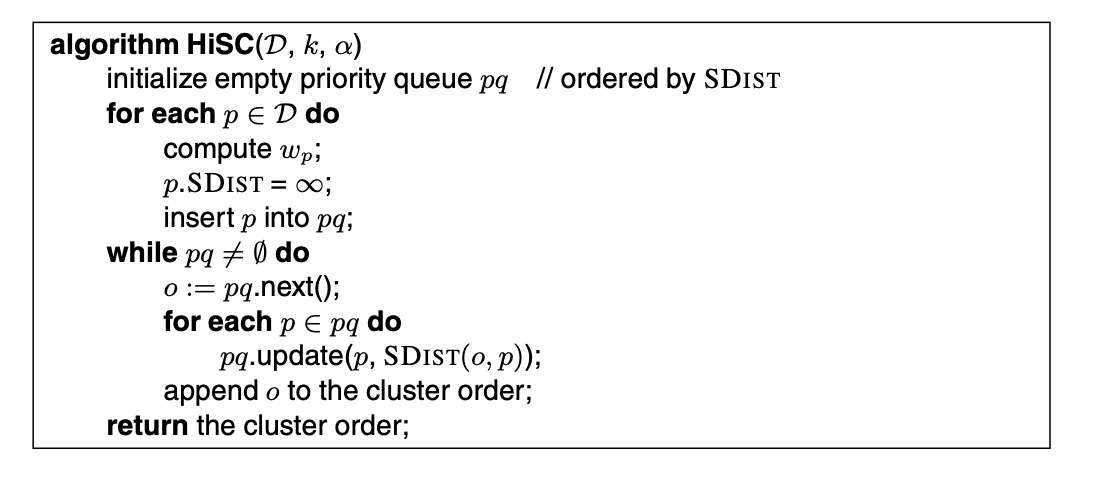

In [14]:
# perform HiSC
from IPython.display import Image
Image("HiSC.png")

#### b.2) Implement HiSC Algorithm from ELKI

In [15]:
import bisect

def HiSC(data, alpha, k, verbose=False):
    """
    Performs the HiSC algorithm.
    Data has the features in the columns and the samples per rows.
    """
    cluster_order = []
    
    # initialize empty priority queue (list that we will keep sorted with bisect)
    pq = []
    
    # get the nearest neighbours
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(data)
    knn_distances, knn_indices = nbrs.kneighbors(data)
    
    # compute w_p
    wp = subsp_pref_vecs(data, knn_indices, alpha)
    
    if verbose:
        print("Subspace vectors:\n", wp)
    
    # the first item is chosen first by default and will be ignored for the pq
    cluster_order.append((np.inf, np.inf, 0))
    
    # insert the remaining datapoints into the pq, where each is a tuple of  
    # d1, d2 (with respect to the first point) and its index in the dataset. 
    # This list will be kept in ascending order, even though popping from the end
    # is faster, because bisect only works that way
    for i in range(1, data.shape[0]):
        pq.append((d1(data, wp, i, 0, alpha),
                   d2(data, wp, i, 0),
                   i))
    # sort everything to get a priority queue that we will keep sorted
    pq.sort()
    
    while len(pq) != 0:
        if verbose:
            print("\n######\nPQ:", pq, "\n\nCluster Order:", cluster_order)
        
        o = pq.pop(0) 
        # !!!!!!!!!!!!!!!
        # for basic_ext it seems to be better to pop from the end, i.e. 
        # take the one with the largest distance (which does not make sense)
        # at least that corresponds to the ELKI debugging we did
        # but it messes up the basic example
        
        if verbose:
            print("\no:", o, "\n")
        
        ## update the distances
        
        # list that remembers the indices in need of updating, so that we can 
        # go back over the list and remove them to not scramble things up
        needs_updating = []
        
        for i in range(len(pq)):
            # calculate the distance to the o that was added last
            dist1 = d1(data, wp, o[2], pq[i][2], alpha)
            dist2 = d2(data, wp, o[2], pq[i][2])
            
            # remember the index of p if it needs updating
            # as well as the tuple to update with
            if dist1 < pq[i][0]  or  (dist1 == pq[i][0] and dist2 < pq[i][1]):
                needs_updating.append( (i, (dist1, dist2, pq[i][2]) ))
                                      
        # remove the indices that need updating
        needs_updating.reverse()
        for tup in needs_updating:
            pq.pop(tup[0])
        
        # put in the updated tuples
        for tup in needs_updating:
            bisect.insort(pq, tup[1])
        
        pq.sort(key=lambda x: (-x[0], +x[1], -x[2]))
        # append o to the cluster order
        cluster_order.append(o)
    
    return cluster_order


## Testing
# data = X_basic
# wp = wp_basic
# alpha = alpha_basic
# k = k_basic

# res = HiSC(data, alpha, k)
# for p in res:
#     print(p)
    
# print("\n~~~~~~~~~~~~~\n")

data = X_ext
wp = wp_ext
alpha = alpha_ext
k = k_ext

clus_ord = HiSC(data, alpha, k, verbose=False)
print("!!!!!!!!!!!!!!!!!")
for p in clus_ord:
    print(p)

!!!!!!!!!!!!!!!!!
(inf, inf, 0)
(5, 0.0, 4)
(6, 0.0, 8)
(3, 0.665438719943467, 3)
(3, 0.03158021532542167, 2)
(2, 0.09952919169771256, 1)
(1, 0.03617499136143649, 6)
(1, 0.06469605861256156, 5)
(1, 0.06929949494765449, 7)


In [16]:
from dataclasses import dataclass, field

# struct for all datapoints
@dataclass
class Point:
    id:           int
    predecessor:  int
    subspace_dim: int
    distance:     float
        
    # overload < (less than) operator    
    def __lt__(self, point_2):
        return (-self.subspace_dim, +self.distance, -self.id) < (-point_2.subspace_dim, +point_2.distance, -point_2.id)           
    # overload string output
    def __str__(self):
        return f'id: {self.id:5}, pred: {self.predecessor:5}, subs: {self.subspace_dim:2}, dist: {self.distance:.5f}'


def HiSC(data, alpha, k, verbose=False):
    """
    Performs the HiSC algorithm.
    Data has the features in the columns and the samples per rows.
    """
    cluster_order = []
    
    # initialize empty priority queue (list that we will keep sorted with bisect)
    pq = []
    
    # get the nearest neighbours
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm="ball_tree").fit(data)
    knn_distances, knn_indices = nbrs.kneighbors(data)
    
    # compute w_p
    wp = subsp_pref_vecs(data, knn_indices, alpha)
    
    if verbose:
        print("Subspace vectors:\n", wp)
    
    # the first item is chosen first by default and will be ignored for the pq
#     cluster_order.append((np.inf, np.inf, 0))
    cluster_order = []
    
    # insert the remaining datapoints into the pq, where each is a tuple of  
    # d1, d2 (with respect to the first point) and its index in the dataset. 
    # This list will be kept in ascending order, even though popping from the end
    # is faster, because bisect only works that way
    for id in range(data.shape[0]):        
        subspace_dim = d1(data, wp, id, 0, alpha)
        distance = d2(data, wp, id, 0)    
        pq.append(Point(id, 0, subspace_dim, distance))
        
    # sort everything to get a priority queue that we will keep sorted
    # pq.sort()
    # not necessary, initially all are sorted by id anyway
    
    while len(pq) != 0:
        if verbose:
            print("\n######\nPQ:", pq, "\n\nCluster Order:", cluster_order)
        
        o = pq.pop(0) 
        # !!!!!!!!!!!!!!!
        # for basic_ext it seems to be better to pop from the end, i.e. 
        # take the one with the largest distance (which does not make sense)
        # at least that corresponds to the ELKI debugging we did
        # but it messes up the basic example
        
        if verbose:
            print("o:", o)
        
        ## update the distances
        
        # list that remembers the indices in need of updating, so that we can 
        # go back over the list and remove them to not scramble things up
        needs_updating = []
        
        for i in range(len(pq)):
            # calculate the distance to the o that was added last
            p = pq[i]
            subspace_dim = d1(data, wp, o.id, p.id, alpha)
            distance     = d2(data, wp, o.id, p.id)
                        
            # remember the index of p if it needs updating
            # as well as the tuple to update with
            if subspace_dim < p.subspace_dim  or\
               (subspace_dim == p.subspace_dim and distance < p.distance):                
                pq[i] = Point(p.id, o.id, subspace_dim, distance)
                                      
                    
        pq.sort(key=lambda x: (-x.subspace_dim, +x.distance, -x.id))
        
        # append o to the cluster order
        cluster_order.append(o)
    
    return cluster_order


# basic extended
# data, y = process_csv("../test_data/basic_ext.csv")
# alpha = 0.006
# k = 3
# clus_ord = HiSC(data, alpha, k, verbose=False)
# for p in clus_ord:
#     print(p)
    
# 
# 3d testfile
data, y = process_csv("../test_data/3-gaussian-3d.csv")
alpha = 0.007
k = 4
clus_ord = HiSC(data, alpha, k, verbose=False)
for p in clus_ord:
    print(p)

# subspaces-5d.csv
# data, y = process_csv("../test_data/subspaces-5d.csv")
# alpha = 0.02
# k = 3
# clus_ord = HiSC(data, alpha, k, verbose=False)
# for p in clus_ord:
#     print(p)    

id:     0, pred:     0, subs:  0, dist: 0.00000
id:   316, pred:     0, subs:  4, dist: 0.00000
id:   307, pred:   316, subs:  3, dist: 0.00000
id:   306, pred:   316, subs:  3, dist: 0.00000
id:   305, pred:   316, subs:  3, dist: 0.00000
id:   302, pred:   316, subs:  3, dist: 0.00000
id:   318, pred:     0, subs:  3, dist: 0.00325
id:   329, pred:   318, subs:  3, dist: 0.00930
id:   324, pred:     0, subs:  3, dist: 0.02935
id:   301, pred:   324, subs:  3, dist: 0.01163
id:   303, pred:     0, subs:  3, dist: 0.04116
id:   326, pred:     0, subs:  3, dist: 0.09977
id:   311, pred:   326, subs:  3, dist: 0.11703
id:   322, pred:   329, subs:  3, dist: 0.35052
id:   300, pred:   322, subs:  3, dist: 0.06071
id:   323, pred:   300, subs:  3, dist: 0.00864
id:   310, pred:   301, subs:  3, dist: 0.42954
id:   327, pred:   310, subs:  3, dist: 0.07691
id:   321, pred:   327, subs:  3, dist: 0.06281
id:   328, pred:     0, subs:  3, dist: 0.66902
id:   325, pred:   328, subs:  3, dist: 

In [17]:
import matplotlib.pyplot as plt

def reachability_plot(cluster_ordering):
    """
    #TODO: improve, e.g. color by label
    """
    sub_dists = [d[0] for d in cluster_ordering]
    
    fig, ax = plt.subplots()
    plt.bar(range(len(cluster_ordering)), sub_dists)

# reachability_plot(clus_ord)

In [18]:
##TODO Comparison in Report

In [19]:
##TODO analyze the clustering result of our algorithm in Report

#### c) perform an exploratory data analysis

#### c.1) Feature Engineering

In [20]:
##TODO

#### c.2) Dimensionality Reduction

In [21]:
##TODO

#### ...

In [22]:
##TODO analyzing in Report